Neste notebook serão realizadas previsões para os anos de 2023 e 2024. 

In [1]:
import numpy as np
import pandas as pd
import preprocess_data as prep
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from models import build_baseline, train_model_using_cross_val, sum_regions_predictions
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


Inicialmente iremos treinar os modelo usando os dados até 2023 para prever o ano de 2023.

In [2]:
STATE = 'CE'
TEST_YEAR = 2023

In [3]:
df = prep.load_cases_data()
df = df.loc[df.uf == STATE]
enso = prep.load_enso_data()

# generate the samples to train and test based on the regional data 
X_train, y_train = prep.generate_regional_train_samples(df, enso, TEST_YEAR, columns_to_normalize=['casos','epiweek', 'enso', 'R0', 'total_cases',
                                                                                                  'peak_week', 'perc_geocode'], episcanner = True)

In [4]:
X_train.shape

(220, 89, 8)

In [5]:
y_train.shape

(220, 52)

Defining a custom activation function

In [7]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

def SigmoReLU(x):
    return K.maximum(tf.keras.activations.relu(x), tf.keras.activations.sigmoid(x))


get_custom_objects().update({'SigmoReLU': tf.keras.layers.Activation(SigmoReLU)})


In [8]:
activation = SigmoReLU

Definição da custom loss: 

In [9]:
def custom_loss(y_true, y_pred):
    '''
    Test of a custom loss function
    '''
    first_log = tf.math.log(y_pred + 1.0)
    second_log = tf.math.log(y_true + 1.0)

    sum_values = abs(tf.reduce_sum(y_pred) - tf.reduce_sum(y_true))

    peak_mag = abs(tf.reduce_max(y_pred) - tf.reduce_max(y_true))

    peak_pos = abs(tf.argmax(y_pred) - tf.argmax(y_true))

    sum_values = tf.cast(sum_values, tf.float32)
    peak_mag = tf.cast(peak_mag, tf.float32)
    peak_pos = tf.cast(peak_pos, tf.float32)

    msle_error = tf.reduce_mean(tf.square(first_log - second_log))

    return msle_error + 0.1*sum_values + 0.1*peak_mag + 0.2*peak_pos


In [10]:
LOSS = custom_loss

In [14]:
batch_size = 4
model = build_baseline( hidden=64, features=8, predict_n=52, look_back=89, loss=LOSS, 
                  stateful = False, batch_size = batch_size,  optimizer = Adam(learning_rate=0.001), activation = activation)

model 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (4, 89, 8)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (4, 89, 64)            │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (4, 89, 64)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (4, 64)                │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (4, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (4, 52)                │         3,380 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,092 (215.20 KB)

 Trainable params: 55,092 (215.20 KB)

 Non-trainable params: 0 (0.00 B)

None


<Functional name=functional_1, built=True>

In [15]:
%%time 
model = train_model_using_cross_val(model, X_train, y_train, n_splits=4, epochs = 150,
                                verbose = 0,
                                batch_size = batch_size, 
                                monitor = 'val_loss',
                                min_delta = 0,
                                patience = 15)

Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
CPU times: user 2min 50s, sys: 23.8 s, total: 3min 14s
Wall time: 3min 27s


In [16]:

model.save(f'saved_models/model_{STATE}_{TEST_YEAR-1}_cl.keras')


Aplicando o modelo para 2023:

In [17]:
df_preds_23 = sum_regions_predictions(model, df, enso,TEST_YEAR,['casos','epiweek', 'enso', 'R0', 'total_cases',
                                                                                                  'peak_week', 'perc_geocode'], True, False )

In [18]:
df_w = df.loc[df.uf == STATE][['casos']].resample('W-SUN').sum()

df_w = prep.add_epiweek_label(df_w)

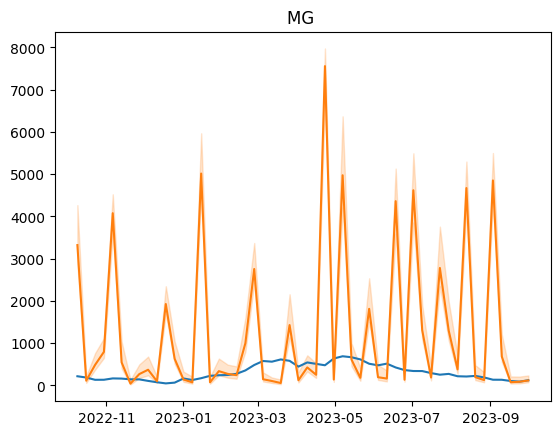

In [19]:
fig, ax = plt.subplots()

ax.plot(df_w.loc[df_w.year == TEST_YEAR].casos, label = 'Data')

ax.plot(df_preds_23.dates, df_preds_23.preds, label = 'preds')

ax.fill_between( df_preds_23.dates, df_preds_23.lower, df_preds_23.upper, color = 'tab:orange', alpha = 0.2)

ax.set_title(f'MG ')

plt.show()

Para fazer as previsões para 2024 iremos retreinar o modelo usando os dados de 2023: 

Devo retreinar tudo novamente mas usando o mesmo modelo como start já que a normalização dos dados mudam?? 

In [20]:
TEST_YEAR = 2024

In [21]:
#regional samples
X_train, y_train = prep.generate_regional_train_samples(df, enso, TEST_YEAR,['casos','epiweek', 'enso', 'R0', 'total_cases',
                                                                                                  'peak_week', 'perc_geocode'], True, False, min_year = 2023)


In [22]:
X_train.shape

(22, 89, 8)

Retrain the model and save:

In [23]:
model.compile(loss=LOSS, optimizer = Adam(learning_rate = 0.0001), metrics=["accuracy", "mape", "mse"])

TB_callback = TensorBoard(
            log_dir="./tensorboard",
            histogram_freq=0,
            write_graph=True,
            write_images=True,
            update_freq='epoch',
            # embeddings_freq=10
        )

hist = model.fit(
            X_train,
            y_train,
            batch_size=4,
            epochs=100,
            verbose=0,
            callbacks=[TB_callback, EarlyStopping(monitor='loss', min_delta=0, patience=20)]
        )

# save the model
model.save(f'saved_models/model_{STATE}_{TEST_YEAR-1}_notebook.keras')


Aplicando o modelo para 2024:

In [24]:
df_preds_24 =  sum_regions_predictions(model, df, enso,TEST_YEAR,['casos','epiweek', 'enso', 'R0', 'total_cases',
                                                                                                  'peak_week', 'perc_geocode'], True, False )

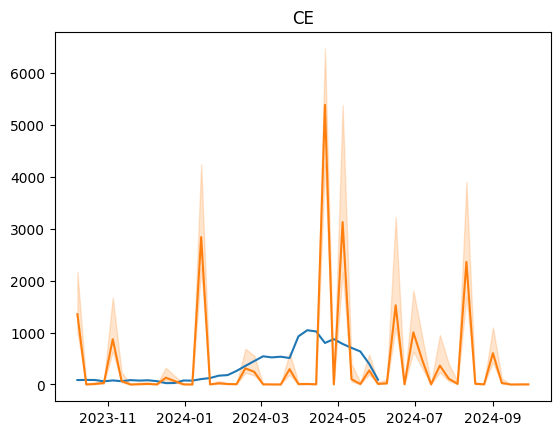

In [25]:
fig, ax = plt.subplots()

ax.plot(df_w.loc[df_w.year == TEST_YEAR].casos, label = 'Data')

ax.plot(df_preds_24.dates, df_preds_24.preds, label = 'preds')

ax.fill_between( df_preds_24.dates, df_preds_24.lower, df_preds_24.upper, color = 'tab:orange', alpha = 0.2)

ax.set_title(f'{STATE}')

plt.show()

Colocando as predições lado a lado e comparando com o valor de baseline salvo: 

In [29]:
df_preds_23_base = pd.read_csv('./predictions/preds_CE_2023_baseline.csv')

df_preds_23_base.dates = pd.to_datetime(df_preds_23_base.dates)

df_preds_24_base = pd.read_csv('./predictions/preds_CE_2024_baseline.csv')

df_preds_24_base.dates = pd.to_datetime(df_preds_24_base.dates)

df_preds_23_base.head()

,dates,lower,preds,upper,adm_1,adm_0,adm_2
0,2022-10-09,274.730948,333.029762,402.139813,CE,BR,NaN
1,2022-10-16,244.698123,280.491309,331.479795,CE,BR,NaN
2,2022-10-23,211.881507,245.762504,282.201750,CE,BR,NaN
3,2022-10-30,243.722948,279.130585,332.810002,CE,BR,NaN
4,2022-11-06,202.281463,255.797165,346.647712,CE,BR,NaN


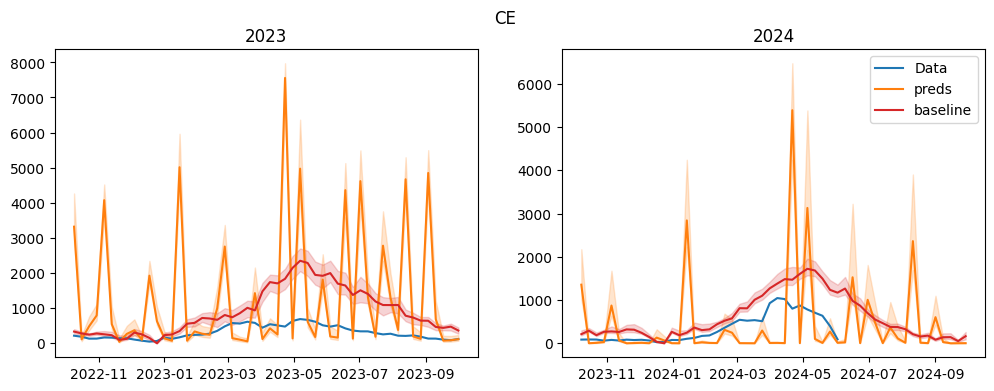

In [30]:
fig, ax = plt.subplots(1,2, figsize = (12, 4))

ax[0].plot(df_w.loc[df_w.year == 2023].casos, label = 'Data')

ax[0].plot(df_preds_23.dates, df_preds_23.preds, label = 'preds')

ax[0].fill_between( df_preds_23.dates, df_preds_23.lower, df_preds_23.upper, color = 'tab:orange', alpha = 0.2)

ax[0].plot(df_preds_23_base.dates, df_preds_23_base.preds, label = 'baseline', color = 'tab:red')

ax[0].fill_between( df_preds_23_base.dates, df_preds_23_base.lower, df_preds_23_base.upper, color = 'tab:red', alpha = 0.2)

ax[0].set_title('2023')

ax[1].plot(df_w.loc[df_w.year == 2024].casos, label = 'Data')

ax[1].plot(df_preds_24.dates, df_preds_24.preds, label = 'preds')

ax[1].fill_between( df_preds_24.dates, df_preds_24.lower, df_preds_24.upper, color = 'tab:orange', alpha = 0.2)

ax[1].plot(df_preds_24_base.dates, df_preds_24_base.preds, label = 'baseline', color = 'tab:red')

ax[1].fill_between( df_preds_24_base.dates, df_preds_24_base.lower, df_preds_24_base.upper, color = 'tab:red', alpha = 0.2)

ax[1].set_title('2024')

ax[1].legend()

plt.suptitle('CE')

plt.show()

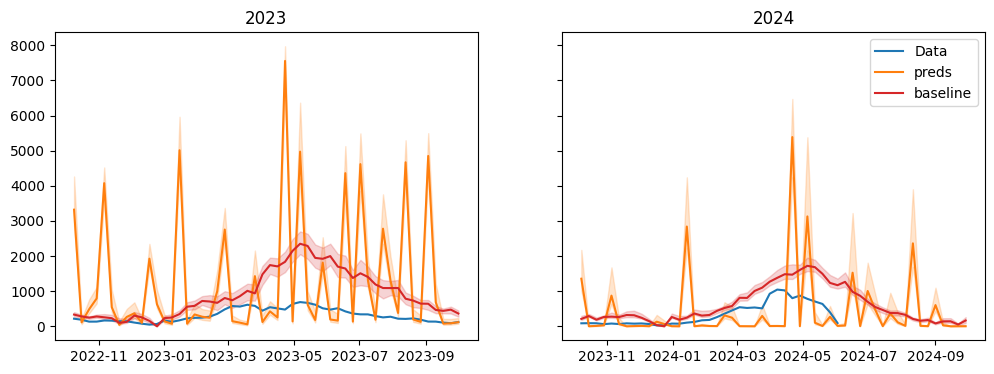

In [31]:
fig, ax = plt.subplots(1,2, figsize = (12, 4), sharey = True)

ax[0].plot(df_w.loc[df_w.year == 2023].casos, label = 'Data')

ax[0].plot(df_preds_23.dates, df_preds_23.preds, label = 'preds')

ax[0].fill_between( df_preds_23.dates, df_preds_23.lower, df_preds_23.upper, color = 'tab:orange', alpha = 0.2)

ax[0].plot(df_preds_23_base.dates, df_preds_23_base.preds, label = 'baseline', color = 'tab:red')

ax[0].fill_between( df_preds_23_base.dates, df_preds_23_base.lower, df_preds_23_base.upper, color = 'tab:red', alpha = 0.2)

ax[0].set_title('2023')

ax[1].plot(df_w.loc[df_w.year == 2024].casos, label = 'Data')

ax[1].plot(df_preds_24.dates, df_preds_24.preds, label = 'preds')

ax[1].fill_between( df_preds_24.dates, df_preds_24.lower, df_preds_24.upper, color = 'tab:orange', alpha = 0.2)

ax[1].plot(df_preds_24_base.dates, df_preds_24_base.preds, label = 'baseline', color = 'tab:red')

ax[1].fill_between( df_preds_24_base.dates, df_preds_24_base.lower, df_preds_24_base.upper, color = 'tab:red', alpha = 0.2)

ax[1].set_title('2024')

ax[1].legend()

plt.show()

In [32]:
df_preds_23.to_csv('./predictions/preds_CE_2023_cl.csv')

df_preds_24.to_csv('./predictions/preds_CE_2024_cl.csv')